<a href="https://colab.research.google.com/github/hbhb0311/LikelionStudy/blob/main/3.HardCoding/2.HardCoding_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import Image
import numpy as np
import csv

np.random.seed(106)

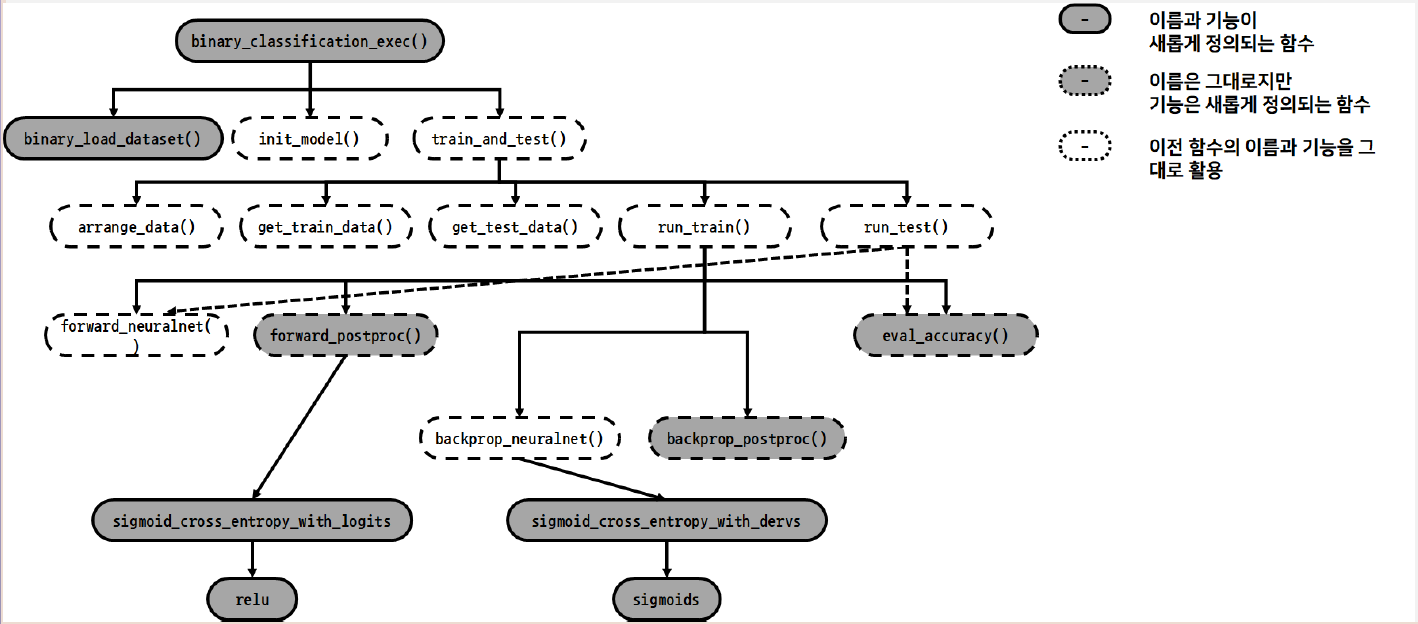

In [2]:
Image('/content/drive/MyDrive/멋쟁이사자처럼/dataset/hardcoding/binary/Untitled.png')

# 1. 하이퍼파라미터값 정의

In [3]:
RND_MEAN = 0
RND_STD = 0.003

LEARNIG_RATE = 0.001
# 정규분포의 평균, 표준편차, 학습률 정의

# 2. 메인 함수 정의

In [4]:
def binary_classification_exec(epoch_count = 10, mb_size = 10, report = 1, train_rate = 0.7):
  binary_load_dataset()
  init_model()
  train_and_test(epoch_count, mb_size, report, train_rate)

## 2-1. 데이터 불러오는 함수 정의

In [5]:
def binary_load_dataset():
  with open('/content/drive/MyDrive/멋쟁이사자처럼/dataset/pulsar_stars.csv') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    rows = []

    for row in csvreader:
      rows.append(row)

    global data, input_cnt, output_cnt

    input_cnt, output_cnt = 8, 1
    data = np.asarray(rows, dtype = 'float32')

## 2-2. 파라미터 초기화 함수 정의

In [6]:
def init_model():
  global weight, bias, input_cnt, output_cnt
  # 함수 밖에서 전역 변수 선언해줬다면, 전역변수 다시 선언해주어야 함
  
  weight = np.random.normal(RND_MEAN, RND_STD, [input_cnt, output_cnt])
  bias = np.zeros([output_cnt])

  # 편향은 초기에 너무 큰 영향을 주어 학습에 역효과를 불러오지 않도록 0으로 초기화

## 2-3. 학습, 테스트 진행 함수 정의

In [7]:
def train_and_test(epoch_count, mb_size, report, train_rate):
  step_count = arrange_data(mb_size, train_rate)
  test_x, test_y = get_test_data()

  for epoch in range(epoch_count):
    losses, accs = [], []
    for n in range(step_count):
      train_x, train_y = get_train_data(mb_size, n)
      loss, acc = run_train(train_x, train_y)
      losses.append(loss)
      accs.append(acc)

    if report > 0 and (epoch + 1) % report == 0:
      acc = run_test(test_x, test_y)
      print('Epoch{}: Train - loss = {:5.3f}, accuracy = {:5.3f}, Test - {:5.3f}'\
            .format(epoch + 1, np.mean(losses), np.mean(accs), acc))
  
  final_acc = run_test(test_x, test_y)
  print('\n 최종 테스트 : final accuracy - {:5.3f}'.format(final_acc))

### 2-3-1. 데이터 섞기 / 훈련, 테스트 데이터 비율로 나눠서 지정

In [8]:
def arrange_data(mb_size, train_rate):
  global data, shuffle_map, test_begin_index
  shuffle_map = np.arange(data.shape[0])
  np.random.shuffle(shuffle_map)
  
  step_count = int(data.shape[0] * train_rate) // mb_size

  test_begin_index = step_count * mb_size

  return step_count

### 2-3-2. 테스트 데이터 가져오기

In [9]:
def get_test_data():
  global shuffle_map, test_begin_index, output_cnt, data
  test_data = data[shuffle_map[test_begin_index:]]

  return test_data[:,:-output_cnt], test_data[:,-output_cnt:]

### 2-3-3. 학습 데이터 가져오기

In [10]:
def get_train_data(mb_size, n):
  global shuffle_map, test_begin_index, data, output_cnt
	
  # 첫 에폭 수행시 학습 데이터 섞어줌
  if n == 0:
    np.random.shuffle(shuffle_map[:test_begin_index])
  
  train_data = data[shuffle_map[mb_size * n : mb_size * (n + 1)]]

  return train_data[:, :-output_cnt], train_data[:, -output_cnt:]

### 2-3-4. 학습 진행하기

In [11]:
def run_train(x, y):
  output, aux_nn = forward_neuralnet(x)
  loss, aux_pp = forward_postproc(output, y)
  # aux_pp = diff (output - y)
  accuracy = eval_accuracy(output, y)

  G_output = backprop_postproc(aux_pp)
  backprop_neuralnet(G_output, aux_nn)

  return loss, accuracy

### 2-3-5. 테스트 진행하기

In [12]:
def run_test(x, y):
  output, _ = forward_neuralnet(x)
  accuracy = eval_accuracy(output, y)

  return accuracy

# 3. 신경망 연산 수행

In [13]:
# 신경망 연산 수행
def forward_neuralnet(x):
  global weight, bias
  output = np.matmul(x, weight) + bias
  # output = XW + B
   
  return output, x

# 4. 손실 구하기

In [14]:
def forward_postproc(output, y):
  CEE = sigmoid_cross_entropy_with_logits(y, output)
  loss = np.mean(CEE)

  return loss, [y, output, CEE]

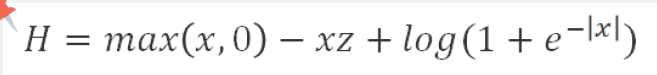

In [15]:
Image('/content/drive/MyDrive/멋쟁이사자처럼/dataset/hardcoding/binary/Untitled 1.png')

In [16]:
def sigmoid_cross_entropy_with_logits(z, x):
  return relu(x) - x*z + np.log(1 + np.exp(-np.abs(x)))

In [17]:
def relu(x):
  return np.maximum(x, 0)

[역전파 개념에 대한 설명](https://sacko.tistory.com/19)

# 5. 교차 엔트로피에 대한 역전파 수행

In [18]:
def backprop_postproc(aux):
  y, output, CEE = aux
  G_loss = 1.0

  g_loss_entropy = 1.0 / np.prod(CEE.shape)
  g_entropy_output = sigmoid_cross_entropy_with_logits_derv(y, output)

  G_entropy = G_loss * g_loss_entropy
  G_output = G_entropy * g_entropy_output

  return G_output

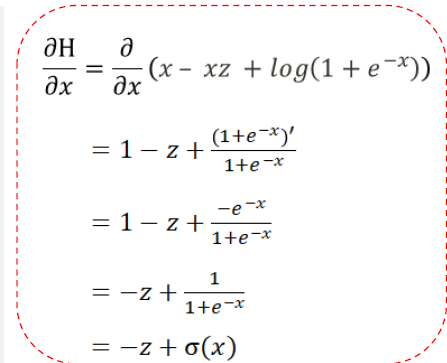

In [19]:
Image('/content/drive/MyDrive/멋쟁이사자처럼/dataset/hardcoding/binary/Untitled 2.png')

In [20]:
def sigmoid_cross_entropy_with_logits_derv(z, x):
  return -z + sigmoid(x)

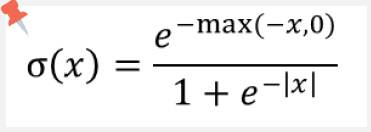

In [21]:
Image('/content/drive/MyDrive/멋쟁이사자처럼/dataset/hardcoding/binary/Untitled 3.png')

In [22]:
def sigmoid(x):
  return np.exp(-relu(-x)) / (1.0 + np.exp(-np.abs(x)))

## 파라미터 갱신

In [23]:
# 파라미터 갱신
def backprop_neuralnet(G_output, x):
  global weight, bias
  G_w = np.matmul(x.transpose(), G_output)
  G_b = np.sum(G_output, axis = 0)

  weight -= LEARNIG_RATE * G_w
  bias -= LEARNIG_RATE * G_b

# 6. 정확도 구하기

In [24]:
def eval_accuracy(output, y):
  estimate = np.greater(output, 0) # output이 0보다 크면 참, 즉 1을 반환 / 0보다 작으면 거짓, 즉 0을 반환
  answer = np.greater(y, 0.5)
  correct = np.equal(estimate, answer)

  return np.mean(correct)

In [25]:
binary_classification_exec() # accuracy가 굉장히 높게 출력 -> data가 편중되어 있었기 때문

Epoch1: Train - loss = 0.146, accuracy = 0.959, Test - 0.948
Epoch2: Train - loss = 0.113, accuracy = 0.969, Test - 0.963
Epoch3: Train - loss = 0.119, accuracy = 0.970, Test - 0.967
Epoch4: Train - loss = 0.113, accuracy = 0.968, Test - 0.971
Epoch5: Train - loss = 0.113, accuracy = 0.969, Test - 0.967
Epoch6: Train - loss = 0.123, accuracy = 0.970, Test - 0.966
Epoch7: Train - loss = 0.109, accuracy = 0.972, Test - 0.971
Epoch8: Train - loss = 0.109, accuracy = 0.970, Test - 0.969
Epoch9: Train - loss = 0.111, accuracy = 0.970, Test - 0.972
Epoch10: Train - loss = 0.112, accuracy = 0.970, Test - 0.955

 최종 테스트 : final accuracy - 0.955


# 더 정밀한 모델 평가 방법

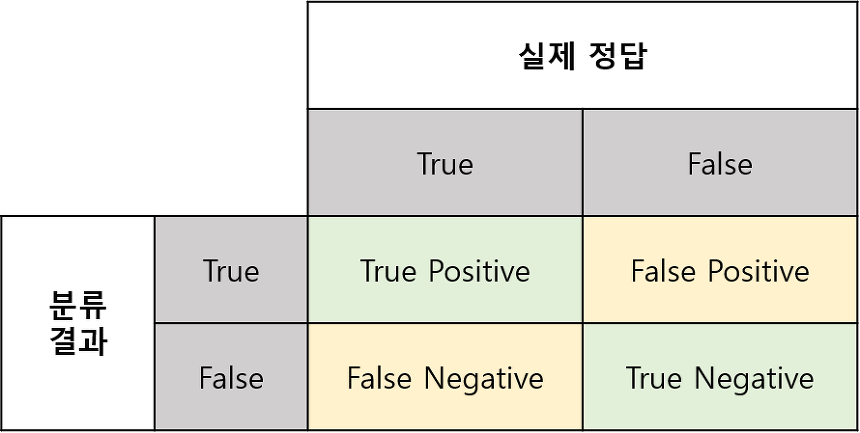

In [26]:
Image('/content/drive/MyDrive/멋쟁이사자처럼/dataset/hardcoding/binary/Untitled 5.png')

출처 : https://sumniya.tistory.com/26

- TP : 신경망이 참으로 예측하였는데 맞는 경우
- TN : 신경망이 거짓으로 예측하였는데 맞는 경우
- FP : 신경망이 참으로 예측하였는데 틀린 경우
- FN : 신경망이 거짓으로 예측하였는데 틀린 경우

T :  예측이 맞음, F : 예측이 틀림, P : 신경망이 참으로 예측, N : 신경망이 거짓으로 예측

[<예시>](https://eunsukimme.github.io/ml/2019/10/21/Accuracy-Recall-Precision-F1-score/)

- `True Positives` - 모델은 성적이 B보다 높을 것이라고 예측하였고 실제로 그런 경우
- `True Negatives` - 모델은 성적이 B보다 낮을 것이라고 예측하였고 실제로 그런 경우
- `False Positives` - 모델은 성적이 B보다 높을 것이라고 예측하였고 실제로는 아닌 경우
- `False Negatives` - 모델은 성적이 B보다 낮을 것이라고 예측하였고 실제로는 아닌 경우

## 정밀도
신경망이 참으로 예측한 것 가운데 정답이 참인 비율

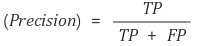

In [27]:
Image('/content/drive/MyDrive/멋쟁이사자처럼/dataset/hardcoding/binary/Untitled 6.png')

## 재현율
정답인 것들 가운데 신경망이 참으로 예측한 비율

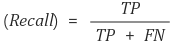

In [28]:
Image('/content/drive/MyDrive/멋쟁이사자처럼/dataset/hardcoding/binary/Untitled 7.png')

⇒ 정밀도와 재현율 모두 높일 수 없음

## F1 score

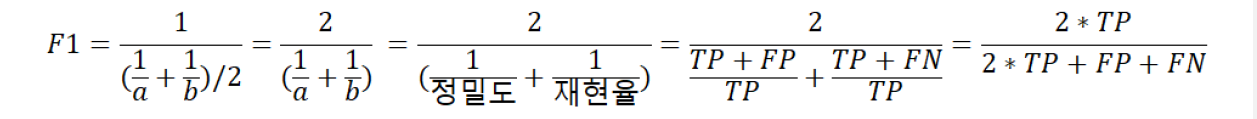

In [29]:
Image('/content/drive/MyDrive/멋쟁이사자처럼/dataset/hardcoding/binary/Untitled 8.png')

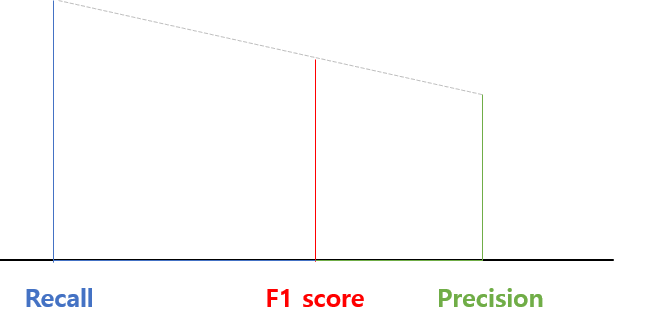

In [30]:
Image('/content/drive/MyDrive/멋쟁이사자처럼/dataset/hardcoding/binary/Untitled 9.png')

- 산술평균이 아닌 조화평균을 사용하는 이유

    기하학적으로 봤을 때, 단순 평균이라기보다는 작은 길이 쪽으로 치우치게 된, 

    그러면서 작은 쪽과 큰 쪽의 사이의 값을 가진 평균이 도출됨

    이렇게 조화평균을 이용하면 산술평균을 이용하는 것보다, 큰 비중이 끼치는 bias가 줄어듦

## 정확도

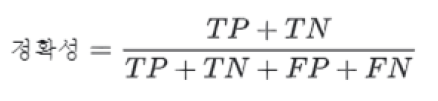

In [31]:
Image('/content/drive/MyDrive/멋쟁이사자처럼/dataset/hardcoding/binary/Untitled 10.png')

# 7. 데이터 증폭

In [32]:
def binary_classification_exec(epoch_count = 10, mb_size = 10, report = 1, train_rate = 0.7, adjust_ratio = False):
  binary_load_dataset(adjust_ratio)
  init_model()
  train_and_test(epoch_count, mb_size, report, train_rate)
# adjust_ratio 라는 인자 추가

In [33]:
def binary_load_dataset(adjust_ratio):
  pulsars, stars = [], []

  with open('/content/drive/MyDrive/멋쟁이사자처럼/dataset/pulsar_stars.csv') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
   
    # 각 라벨에 맞게 데이터 분리해서 append 해줌
    for row in csvreader:
      if row[8] == '1': 
        pulsars.append(row) 
      else:
        stars.append(row)

    global data, input_cnt, output_cnt

    input_cnt, output_cnt = 8, 1
    star_cnt, pulsar_cnt = len(stars), len(pulsars)

    if adjust_ratio:
      data = np.zeros([2 * star_cnt, 9]) # star 데이터 개수의 2배 만큼 버퍼 만들어줌
      data[0:star_cnt, :] = np.asarray(stars, dtype = 'float32') # 그 중 절반은 star 데이터 담아줌

      for i in range(star_cnt):
        data[star_cnt + i] = np.asarray(pulsars[i % pulsar_cnt], dtype = 'float32')
    else:
      data = np.zeros([star_cnt + pulsar_cnt, 9])
      data[0:star_cnt, :] = np.asarray(stars, dtype = 'float32')
      data[star_cnt: , :] = np.asarray(pulsars, dtype = 'float32')

# 모델 평가 방법을 추가해 다시 모델 생성

In [34]:
def eval_accuracy(output, y):
  est_yes = np.greater(output, 0)
  ans_yes = np.greater(y, 0.5)

  est_no = np.logical_not(est_yes)
  ans_no = np.logical_not(ans_yes)

  tp = np.sum(np.logical_and(est_yes, ans_yes))
  fp = np.sum(np.logical_and(est_yes, ans_no))
  fn = np.sum(np.logical_and(est_no, ans_yes))
  tn = np.sum(np.logical_and(est_no, ans_no))

  accuracy = safe_div(tp+tn, tp+fp+fn+tn)
  precision = safe_div(tp, tp+fp)
  recall = safe_div(tp, tp+fn)

  f1 = 2 * safe_div(recall * precision, (recall + precision))

  return [accuracy, precision, recall, f1]

In [35]:
def safe_div(p, q):
  p, q = float(p), float(q)
  if np.abs(q) < 1.0e-20:
    return np.sign(p)
  return p / q

In [36]:
def train_and_test(epoch_count, mb_size, report, train_rate):
  step_count = arrange_data(mb_size, train_rate)
  test_x, test_y = get_test_data()

  for epoch in range(epoch_count):
    losses, accs = [], []

    for i in range(mb_size):
      train_x, train_y = get_train_data(mb_size, i)
      loss, acc = run_train(train_x, train_y)
      losses.append(loss)
      accs.append(acc)

    if report > 0 and (epoch + 1) % report == 0:
      acc = run_test(test_x, test_y)
      print('Epoch {} : Train - loss = {:5.3f} \n accuracy = {:5.3f}, precision = {:5.3f}, recall = {:5.3f}, f1 = {:5.3f}'\
                  .format(epoch+1, np.mean(losses), acc[0], acc[1], acc[2], acc[3]))
      
  final_acc = run_test(test_x, test_y)
  print('\n 최종 테스트 \n Final accuracy - {:5.3f}, precision = {:5.3f}, recall = {:5.3f}, f1 = {:5.3f}'\
                  .format(final_acc[0], final_acc[1], final_acc[2], final_acc[3]))

## 데이터 증폭 X

In [37]:
binary_classification_exec(adjust_ratio = False)

Epoch 1 : Train - loss = 0.379 
 accuracy = 0.939, precision = 0.667, recall = 0.658, f1 = 0.663
Epoch 2 : Train - loss = 0.215 
 accuracy = 0.952, precision = 0.953, recall = 0.501, f1 = 0.657
Epoch 3 : Train - loss = 0.197 
 accuracy = 0.954, precision = 0.988, recall = 0.499, f1 = 0.663
Epoch 4 : Train - loss = 0.243 
 accuracy = 0.955, precision = 0.981, recall = 0.515, f1 = 0.676
Epoch 5 : Train - loss = 0.097 
 accuracy = 0.960, precision = 0.957, recall = 0.587, f1 = 0.728
Epoch 6 : Train - loss = 0.081 
 accuracy = 0.955, precision = 0.988, recall = 0.513, f1 = 0.676
Epoch 7 : Train - loss = 0.142 
 accuracy = 0.964, precision = 0.957, recall = 0.636, f1 = 0.764
Epoch 8 : Train - loss = 0.120 
 accuracy = 0.962, precision = 0.833, recall = 0.734, f1 = 0.780
Epoch 9 : Train - loss = 0.104 
 accuracy = 0.962, precision = 0.983, recall = 0.597, f1 = 0.743
Epoch 10 : Train - loss = 0.344 
 accuracy = 0.967, precision = 0.941, recall = 0.685, f1 = 0.793

 최종 테스트 
 Final accuracy - 0

## 데이터 증폭 O

In [38]:
binary_classification_exec(adjust_ratio = True)

Epoch 1 : Train - loss = 0.583 
 accuracy = 0.871, precision = 0.854, recall = 0.893, f1 = 0.873
Epoch 2 : Train - loss = 1.012 
 accuracy = 0.891, precision = 0.872, recall = 0.913, f1 = 0.892
Epoch 3 : Train - loss = 0.626 
 accuracy = 0.825, precision = 0.964, recall = 0.672, f1 = 0.792
Epoch 4 : Train - loss = 0.418 
 accuracy = 0.876, precision = 0.853, recall = 0.906, f1 = 0.879
Epoch 5 : Train - loss = 0.407 
 accuracy = 0.820, precision = 0.757, recall = 0.940, f1 = 0.838
Epoch 6 : Train - loss = 0.594 
 accuracy = 0.755, precision = 0.998, recall = 0.507, f1 = 0.672
Epoch 7 : Train - loss = 0.350 
 accuracy = 0.887, precision = 0.874, recall = 0.904, f1 = 0.888
Epoch 8 : Train - loss = 0.227 
 accuracy = 0.887, precision = 0.942, recall = 0.824, f1 = 0.879
Epoch 9 : Train - loss = 0.317 
 accuracy = 0.896, precision = 0.870, recall = 0.931, f1 = 0.899
Epoch 10 : Train - loss = 0.511 
 accuracy = 0.862, precision = 0.975, recall = 0.742, f1 = 0.843

 최종 테스트 
 Final accuracy - 0

→ 정확도는 데이터 증폭하지 않았을 때 보다 낮으나 다른 지표들에서는 수치가 높게 나옴